# FS2024: 31088/61088 Deep Learning 
## First Assignment
### Student: Eduardo Amaral
### Matriculation Number: EU-110079796
#### [Project Description](https://github.com/rolimans/deepLearningFirstAssignment/blob/main/description.pdf)

#### Libraries Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose

from torchsummary import summary

#### Seed Initialization (for reproducibility) and Helper Functions

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

def resetModelWeights(model):
  for module in model.modules():
    if hasattr(module, 'reset_parameters'):
      module.reset_parameters()


#### PyTorch Device Configuration

In [3]:
def canUseMps():
  return torch.backends.mps.is_available() and torch.backends.mps.is_built()

def canUseCuda():
  return torch.cuda.is_available()

def getBestDevice():
  if canUseCuda():
    return torch.device('cuda')
  elif canUseMps():
    return torch.device('mps')
  else:
    return torch.device('cpu')
  
device = getBestDevice()

print(f'Torch version: {torch.__version__}')
print(f'Device: {device}')


Torch version: 2.2.2
Device: mps


## 1. Introduction
**In this assignment you need to upload a zip file to ILIAS which includes:**

1. A Jupyter Notebook file Assignment1.ipynb completed with code and answers and;
2. a Jupyter Notebook exported to HTML (File/Export Notebook as HTML).

**The zip file name must be FirstName LastName.zip. If your implementation requires auxiliary functions, you must implement those functions inside a corresponding .py file.**

Please state your name at the beginning of the notebook.

### 1.1 Notes on Code and Submission Quality

In addition to answering the different questions, you are also expected to provide well written submissions. Here are some recommendations to take into consideration:

- Please answer the question in the same order as in the assignment and use the same question numbers.
- Don’t answer the questions in the code comments. Use the text cells in your notebook.
- Remove clutter such as unused code lines instead of turning them into comments.
- Make sure the right execution order of the notebook cells is from top to bottom.
  - A TA should be able to reproduce your results by simply clicking ”Run All” without having to guess which cells should be executed first.

Poorly written submissions might result in points deduction.



## 2. Problem

Pneumonia is a medical condition characterized by inflammation and infection of the air sacs in one or both lungs.

Detecting pneumonia can be done using various methods like CT scans, pulse oximetry, and others, with the most common method being X-ray imaging.

However, interpreting chest X-rays (CXR) can be challenging and subject to differences in interpretation.

In this task, our aim is to develop a model for pneumonia detection that determines whether a given chest X-ray has pneumonia or not.

The dataset is accessible [here](https://github.com/rolimans/deepLearningFirstAssignment/raw/main/resources/data.zip).

<img src="resources/image1.png" alt="First Image" style="width: 350px;"/>
<img src="resources/image2.png" alt="Second Image" style="width: 350px;"/>

<br></br>

<center> Figure 1: An illustrative example of Chest X-ray in patients with clear lungs without any areas of abnormal opacification (<strong>Left</strong>) and an example of Chest X-ray with bacterial pneumonia (<strong>Right</strong>). </center>


## Tasks

### 1. [Total 60 pts] Train a fully connected neural network and convolutional neural network for binary classification.

You will implement and train a fully connected neural network and convolutional neural network for binary classification to predict whether a given chest X-ray has pneumonia or not (see Figure 1).

To access the data, first extract *data.zip*.

Folders *train* and *val* contain the train and validation datasets respectively.

##### Dowloading the Dataset

In [4]:
!rm -rf data
!mkdir data
!wget -q https://github.com/rolimans/deepLearningFirstAssignment/raw/main/resources/data.zip -O data/data.zip
!unzip -q data/data.zip -d data
!rm -rf data/data.zip

#### [10 pts] Create Dataset and DataLoader objects for provided training and validation data (folders train and val). Visualize few images from each class.

##### Setting up paths, configuring transformations and reading ImageFolders.

In [5]:
dataDir = 'data/chest_xray_64'

trainDataDir = f'{dataDir}/train'
valDataDir = f'{dataDir}/val'

targetSize = (64, 64)

imageTransformers = Compose([
    Resize(targetSize),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

corruptedFiles = []

trainDatasetImgs = ImageFolder(trainDataDir, is_valid_file=lambda f: f.endswith("jpeg") or f.endswith("jpg") and f not in corruptedFiles)
valDatasetImgs= ImageFolder(valDataDir, is_valid_file=lambda f: f.endswith("jpeg") or f.endswith("jpg") and f not in corruptedFiles)

print(f'Train dataset size: {len(trainDatasetImgs)}')
print(f'Validation dataset size: {len(valDatasetImgs)}')
print(f'Train dataset labels: {trainDatasetImgs.classes}')
print(f'Validation dataset labels: {valDatasetImgs.classes}')

Train dataset size: 5216
Validation dataset size: 624
Train dataset labels: ['NORMAL', 'PNEUMONIA']
Validation dataset labels: ['NORMAL', 'PNEUMONIA']


##### Creating custom Dataset Class

In [6]:
class XRayDataset(Dataset):
  def __init__(self, dataset, transform=None):
    data = []
    for sample in tqdm(dataset):
      data.append(sample)
    self.n = len(data)
    self.data = data
    self.transform = transform
    
  def __getitem__(self, ind):
    if self.transform is not None:
      return self.transform(self.data[ind][0]), self.data[ind][1]
    else:
      return self.data[ind]
  
  def set_tranform(self, transform):
    self.transform = transform
  
  def __len__(self):
    return self.n

In [7]:
trainDataset = XRayDataset(trainDatasetImgs, imageTransformers)
valDataset = XRayDataset(valDatasetImgs, imageTransformers)

100%|██████████| 624/624 [00:00<00:00, 9537.51it/s]


##### Getting DataLoaders and Visualizing Image Samples

In [8]:
def functionGetDataLoaders(batchSize):
  # Using num_workers=2 breaks functionality in Jupyter Notebook if class is not declared in external .py file
  trainDataLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
  valDataLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False)
  return trainDataLoader, valDataLoader

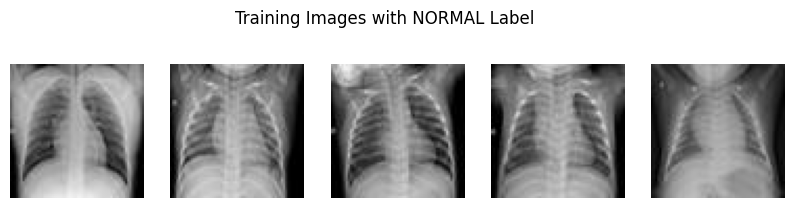

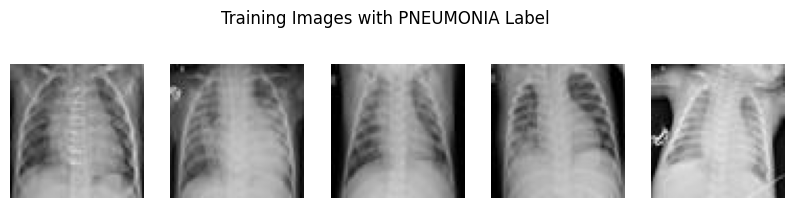

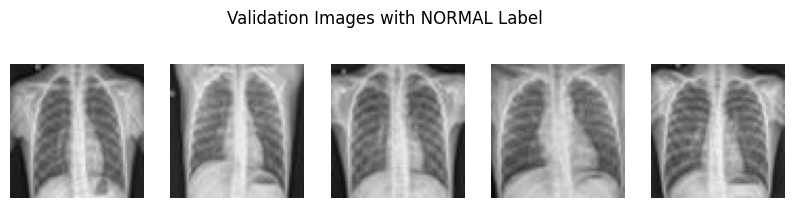

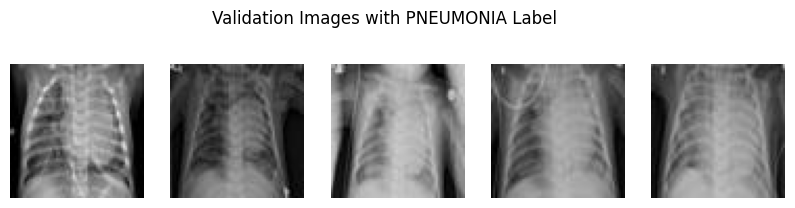

In [9]:
def getNImageSamples(dataLoder, label, n=5):
    imgs = []
    for images, labels in dataLoder:
        imgs += images[labels == label]
        if len(imgs) >= n:
            break
    return imgs[:n]

def showImages(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2.5))
    for i in range(len(images)):
        axes[i].imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

classes = trainDatasetImgs.classes

tmpTrainDataLoader, tmpValDataLoader = functionGetDataLoaders(10)

normalTrainImages = getNImageSamples(tmpTrainDataLoader, classes.index('NORMAL'), 5)
pneumoniaTrainImages = getNImageSamples(tmpTrainDataLoader, classes.index('PNEUMONIA'), 5)

normalValImages = getNImageSamples(tmpValDataLoader, classes.index('NORMAL'), 5)
pneumoniaValImages = getNImageSamples(tmpValDataLoader, classes.index('PNEUMONIA'), 5)

showImages(normalTrainImages, 'Training Images with NORMAL Label')
showImages(pneumoniaTrainImages, 'Training Images with PNEUMONIA Label')

showImages(normalValImages, 'Validation Images with NORMAL Label')
showImages(pneumoniaValImages, 'Validation Images with PNEUMONIA Label')

#### [10 pts] Implement the MLP model according to the definition below:

- Fully connected layer, out_features=128
- Activation function ReLU
- Fully connected layer, out_features=128
- Activation function ReLU
- Fully connected layer, out_features=128
- Activation function ReLU
- Fully connected layer, out_features=128
- Activation function ReLU
- Fully connected layer, out_features=2

In [10]:
class MLPModel(nn.Module):
  
  def __init__(self, inputDim):

    super(MLPModel, self).__init__()

    self.layers = nn.Sequential(
      nn.Linear(inputDim, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, 2)
    )
  
  def forward(self, input):
    input = input.view(input.size(0), -1) # Flatten the input
    return self.layers(input)

In [11]:
inputDim = targetSize[0] * targetSize[1] * 3

model = MLPModel(inputDim)

print(model)
summary(model, (3, targetSize[0], targetSize[1]))

MLPModel(
  (layers): Sequential(
    (0): Linear(in_features=12288, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=2, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]       1,572,992
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
              ReLU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
         

#### [15 pts] Implement a convolutional model according to the definition below:

- Convolutional layer, kernel size 3x3, stride 1, 32 channels
- Max Pooling layer, kernel size 3x3, stride 2, ceil mode=True
- Activation function ReLU
- Convolutional layer, kernel size 3x3, stride 1, 64 channels
- Max Pooling layer, kernel size 3x3, stride 2
- Activation function ReLU
- Convolutional layer, kernel size 3x3, stride 1, 64 channels
- Max Pooling layer, kernel size 2x2, stride 2
- Activation function ReLU
- Convolutional layer, kernel size 2x2, stride 1, 128 channels
- Activation function ReLU
- Convolutional layer, kernel size 3x3, stride 1, 256 channels
- Activation function ReLU
- Convolutional layer, kernel size 3x3, stride 1, 256 channels
- Activation function ReLU
- Convolutional layer, kernel size 1x1, stride 1, 2 (output) channels

In [12]:
class ConvModel(nn.Module):
  
  def __init__(self):

    super(ConvModel, self).__init__()
    
    self.conv_layers = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0), # kernel size 3x3, stride 1, 32 channels
      nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True), # kernel size 3x3, stride 2, ceil mode=True
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0), # kernel size 3x3, stride 1, 64 channels
      nn.MaxPool2d(kernel_size=3, stride=2), # kernel size 3x3, stride 2
      nn.ReLU(),
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0), # kernel size 3x3, stride 1, 64 channels
      nn.MaxPool2d(kernel_size=2, stride=2), # kernel size 2x2, stride 2
      nn.ReLU(),
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0), # kernel size 2x2, stride 1, 128 channels
      nn.ReLU(),
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0), # kernel size 3x3, stride 1, 256 channels
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0), # kernel size 3x3, stride 1, 256 channels
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels=2, kernel_size=1, stride=1, padding=0), # kernel size 1x1, stride 1, 2 channels
    )

  def forward(self, input):
    return self.conv_layers(input).view(input.size(0), -1) # Flatten the output

In [13]:
model = ConvModel()

print(model)
summary(model, (3, targetSize[0], targetSize[1]))

ConvModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (10): ReLU()
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU()
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (14): ReLU()
    (15): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]        

#### [20 pts] Write the training code and train the network you implemented.

- Train for 30 epochs with a batch size of 32.
- Optimize the cross entropy loss.
- Use Adam optimizer with learning rate 1e-3.


##### Defining Training, Testing and Fit Functions

In [14]:
def trainForOneEpoch(model, trainLoader, optimizer, lossFn, device, epoch, totalEpochs):
  model.train()
  losses = []
  nCorrect = 0
  
  for images, labels in tqdm(trainLoader, desc=f'Training Epoch {epoch}/{totalEpochs}'):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    output = model(images)
    loss = lossFn(output, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    nCorrect += torch.sum(output.argmax(1) == labels).item()
  accuracy = 100.0 * nCorrect / len(trainLoader.dataset)
  return np.mean(np.array(losses)), accuracy

In [15]:
def testModel(model, testLoader, lossFn, device, epoch, totalEpochs):
  model.eval()
  testLoss = 0
  nCorrect = 0
  with torch.no_grad():
    for images, labels in tqdm(testLoader, desc=f'Testing Epoch {epoch}/{totalEpochs}'):
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = lossFn(output, labels)
      testLoss += loss.item()
      nCorrect += torch.sum(output.argmax(1) == labels).item()

  averageLoss = testLoss / len(testLoader)
  accuracy = 100.0 * nCorrect / len(testLoader.dataset)
  return averageLoss, accuracy

In [16]:
def fit(trainLoader, valLoader, model, optimizer, lossFn, nEpochs, device):
  trainLosses, trainAccuracies = [], []
  valLosses, valAccuracies = [], []

  for epoch in range(nEpochs):
    trainLoss, trainAccuracy = trainForOneEpoch(model, trainLoader, optimizer, lossFn, device, epoch+1, nEpochs)
    valLoss, valAccuracy = testModel(model, valLoader, lossFn, device, epoch+1, nEpochs)
    trainLosses.append(trainLoss)
    trainAccuracies.append(trainAccuracy)
    valLosses.append(valLoss)
    valAccuracies.append(valAccuracy)
    
    print(f'Epoch {epoch+1}/{nEpochs}: trainLoss: {trainLosses[-1]:.4f}, trainAccuracy: {trainAccuracies[-1]:.4f}, valLoss: {valLosses[-1]:.4f}, valAccuracy: {valAccuracies[-1]:.4f}')
    print('=' * 80)
  
  return trainLosses, trainAccuracies, valLosses, valAccuracies

##### Setting up Training Parameters

In [17]:
batchSize = 32
nEpochs = 30
learningRate = 1e-3

trainLoader, valLoader = functionGetDataLoaders(batchSize)

##### Training the MLP Model

In [18]:
mlpModel = MLPModel(targetSize[0] * targetSize[1] * 3)
mlpModel = mlpModel.to(device)
resetModelWeights(mlpModel)

mlpCurves = fit(trainLoader, valLoader, mlpModel, Adam(mlpModel.parameters(), lr=learningRate), nn.CrossEntropyLoss(), nEpochs, device)

del mlpModel

Testing Epoch 1/30: 100%|██████████| 20/20 [00:00<00:00, 181.05it/s]


Epoch 1/30: trainLoss: 0.1847, trainAccuracy: 92.8873, valLoss: 0.9020, valAccuracy: 77.4038


Testing Epoch 2/30: 100%|██████████| 20/20 [00:00<00:00, 226.07it/s]


Epoch 2/30: trainLoss: 0.1202, trainAccuracy: 95.8206, valLoss: 0.8790, valAccuracy: 75.3205


Testing Epoch 3/30: 100%|██████████| 20/20 [00:00<00:00, 233.05it/s]


Epoch 3/30: trainLoss: 0.1098, trainAccuracy: 96.1656, valLoss: 0.4843, valAccuracy: 83.1731


Testing Epoch 4/30: 100%|██████████| 20/20 [00:00<00:00, 224.81it/s]


Epoch 4/30: trainLoss: 0.0886, trainAccuracy: 96.6258, valLoss: 1.0168, valAccuracy: 77.7244


Testing Epoch 5/30: 100%|██████████| 20/20 [00:00<00:00, 258.87it/s]


Epoch 5/30: trainLoss: 0.0757, trainAccuracy: 97.2776, valLoss: 0.6925, valAccuracy: 80.2885


Testing Epoch 6/30: 100%|██████████| 20/20 [00:00<00:00, 263.67it/s]


Epoch 6/30: trainLoss: 0.0785, trainAccuracy: 97.1434, valLoss: 0.9193, valAccuracy: 77.7244


Testing Epoch 7/30: 100%|██████████| 20/20 [00:00<00:00, 264.82it/s]


Epoch 7/30: trainLoss: 0.0675, trainAccuracy: 97.4118, valLoss: 1.1372, valAccuracy: 75.8013


Testing Epoch 8/30: 100%|██████████| 20/20 [00:00<00:00, 233.84it/s]


Epoch 8/30: trainLoss: 0.0598, trainAccuracy: 97.8719, valLoss: 1.6891, valAccuracy: 75.1603


Testing Epoch 9/30: 100%|██████████| 20/20 [00:00<00:00, 265.52it/s]


Epoch 9/30: trainLoss: 0.0514, trainAccuracy: 98.0445, valLoss: 1.3248, valAccuracy: 79.6474


Testing Epoch 10/30: 100%|██████████| 20/20 [00:00<00:00, 272.20it/s]


Epoch 10/30: trainLoss: 0.0494, trainAccuracy: 98.2170, valLoss: 0.7960, valAccuracy: 79.0064


Testing Epoch 11/30: 100%|██████████| 20/20 [00:00<00:00, 279.19it/s]


Epoch 11/30: trainLoss: 0.0411, trainAccuracy: 98.4279, valLoss: 0.7819, valAccuracy: 80.7692


Testing Epoch 12/30: 100%|██████████| 20/20 [00:00<00:00, 272.41it/s]


Epoch 12/30: trainLoss: 0.0365, trainAccuracy: 98.5621, valLoss: 1.6477, valAccuracy: 79.4872


Testing Epoch 13/30: 100%|██████████| 20/20 [00:00<00:00, 263.55it/s]


Epoch 13/30: trainLoss: 0.0353, trainAccuracy: 98.7155, valLoss: 1.6253, valAccuracy: 75.0000


Testing Epoch 14/30: 100%|██████████| 20/20 [00:00<00:00, 240.69it/s]


Epoch 14/30: trainLoss: 0.0330, trainAccuracy: 98.6963, valLoss: 2.1980, valAccuracy: 75.3205


Testing Epoch 15/30: 100%|██████████| 20/20 [00:00<00:00, 212.08it/s]


Epoch 15/30: trainLoss: 0.0302, trainAccuracy: 98.8113, valLoss: 2.1625, valAccuracy: 77.4038


Testing Epoch 16/30: 100%|██████████| 20/20 [00:00<00:00, 267.54it/s]


Epoch 16/30: trainLoss: 0.0291, trainAccuracy: 98.8689, valLoss: 2.3556, valAccuracy: 77.0833


Testing Epoch 17/30: 100%|██████████| 20/20 [00:00<00:00, 261.25it/s]


Epoch 17/30: trainLoss: 0.0226, trainAccuracy: 98.9456, valLoss: 2.9264, valAccuracy: 76.9231


Testing Epoch 18/30: 100%|██████████| 20/20 [00:00<00:00, 263.94it/s]


Epoch 18/30: trainLoss: 0.0237, trainAccuracy: 98.9839, valLoss: 3.8373, valAccuracy: 74.0385


Testing Epoch 19/30: 100%|██████████| 20/20 [00:00<00:00, 265.80it/s]


Epoch 19/30: trainLoss: 0.0313, trainAccuracy: 98.8689, valLoss: 2.0667, valAccuracy: 74.8397


Testing Epoch 20/30: 100%|██████████| 20/20 [00:00<00:00, 268.94it/s]


Epoch 20/30: trainLoss: 0.0240, trainAccuracy: 99.2140, valLoss: 2.3852, valAccuracy: 79.0064


Testing Epoch 21/30: 100%|██████████| 20/20 [00:00<00:00, 260.97it/s]


Epoch 21/30: trainLoss: 0.0313, trainAccuracy: 98.7347, valLoss: 4.3247, valAccuracy: 74.8397


Testing Epoch 22/30: 100%|██████████| 20/20 [00:00<00:00, 261.90it/s]


Epoch 22/30: trainLoss: 0.0221, trainAccuracy: 99.1948, valLoss: 3.2357, valAccuracy: 74.8397


Testing Epoch 23/30: 100%|██████████| 20/20 [00:00<00:00, 269.89it/s]


Epoch 23/30: trainLoss: 0.0143, trainAccuracy: 99.5399, valLoss: 2.6141, valAccuracy: 80.7692


Testing Epoch 24/30: 100%|██████████| 20/20 [00:00<00:00, 266.08it/s]


Epoch 24/30: trainLoss: 0.0110, trainAccuracy: 99.5782, valLoss: 2.6544, valAccuracy: 77.5641


Testing Epoch 25/30: 100%|██████████| 20/20 [00:00<00:00, 258.06it/s]


Epoch 25/30: trainLoss: 0.0206, trainAccuracy: 99.5207, valLoss: 2.0833, valAccuracy: 77.0833


Testing Epoch 26/30: 100%|██████████| 20/20 [00:00<00:00, 255.94it/s]


Epoch 26/30: trainLoss: 0.0156, trainAccuracy: 99.5015, valLoss: 2.4837, valAccuracy: 77.8846


Testing Epoch 27/30: 100%|██████████| 20/20 [00:00<00:00, 265.11it/s]


Epoch 27/30: trainLoss: 0.0151, trainAccuracy: 99.4440, valLoss: 2.9900, valAccuracy: 76.1218


Testing Epoch 28/30: 100%|██████████| 20/20 [00:00<00:00, 260.46it/s]


Epoch 28/30: trainLoss: 0.0125, trainAccuracy: 99.6741, valLoss: 2.5272, valAccuracy: 75.3205


Testing Epoch 29/30: 100%|██████████| 20/20 [00:00<00:00, 267.37it/s]


Epoch 29/30: trainLoss: 0.0331, trainAccuracy: 98.8305, valLoss: 1.9258, valAccuracy: 77.2436


Testing Epoch 30/30: 100%|██████████| 20/20 [00:00<00:00, 263.50it/s]

Epoch 30/30: trainLoss: 0.0150, trainAccuracy: 99.3482, valLoss: 3.4619, valAccuracy: 77.7244


##### Training the CNN Model

In [19]:
convModel = ConvModel()
convModel = convModel.to(device)
resetModelWeights(convModel)

convCurves = fit(trainLoader, valLoader, convModel, Adam(convModel.parameters(), lr=learningRate), nn.CrossEntropyLoss(), nEpochs, device)

del convModel

Testing Epoch 1/30: 100%|██████████| 20/20 [00:00<00:00, 133.00it/s]


Epoch 1/30: trainLoss: 0.3466, trainAccuracy: 83.8765, valLoss: 0.5547, valAccuracy: 76.2821


Testing Epoch 2/30: 100%|██████████| 20/20 [00:00<00:00, 203.99it/s]


Epoch 2/30: trainLoss: 0.1423, trainAccuracy: 94.4018, valLoss: 0.5126, valAccuracy: 81.7308


Testing Epoch 3/30: 100%|██████████| 20/20 [00:00<00:00, 230.25it/s]


Epoch 3/30: trainLoss: 0.1027, trainAccuracy: 96.0890, valLoss: 0.5856, valAccuracy: 76.7628


Testing Epoch 4/30: 100%|██████████| 20/20 [00:00<00:00, 192.46it/s]


Epoch 4/30: trainLoss: 0.0762, trainAccuracy: 97.0859, valLoss: 0.8518, valAccuracy: 76.2821


Testing Epoch 5/30: 100%|██████████| 20/20 [00:00<00:00, 188.60it/s]


Epoch 5/30: trainLoss: 0.0666, trainAccuracy: 97.5460, valLoss: 0.7153, valAccuracy: 77.0833


Testing Epoch 6/30: 100%|██████████| 20/20 [00:00<00:00, 187.05it/s]


Epoch 6/30: trainLoss: 0.0628, trainAccuracy: 97.8911, valLoss: 0.6743, valAccuracy: 78.3654


Testing Epoch 7/30: 100%|██████████| 20/20 [00:00<00:00, 222.83it/s]


Epoch 7/30: trainLoss: 0.0511, trainAccuracy: 97.9294, valLoss: 0.8570, valAccuracy: 78.0449


Testing Epoch 8/30: 100%|██████████| 20/20 [00:00<00:00, 204.78it/s]


Epoch 8/30: trainLoss: 0.0511, trainAccuracy: 98.0061, valLoss: 1.0207, valAccuracy: 73.2372


Testing Epoch 9/30: 100%|██████████| 20/20 [00:00<00:00, 175.71it/s]


Epoch 9/30: trainLoss: 0.0433, trainAccuracy: 98.4854, valLoss: 0.7724, valAccuracy: 80.2885


Testing Epoch 10/30: 100%|██████████| 20/20 [00:00<00:00, 186.24it/s]


Epoch 10/30: trainLoss: 0.0363, trainAccuracy: 98.6580, valLoss: 1.0263, valAccuracy: 76.2821


Testing Epoch 11/30: 100%|██████████| 20/20 [00:00<00:00, 203.75it/s]


Epoch 11/30: trainLoss: 0.0399, trainAccuracy: 98.3896, valLoss: 0.7706, valAccuracy: 83.0128


Testing Epoch 12/30: 100%|██████████| 20/20 [00:00<00:00, 224.63it/s]


Epoch 12/30: trainLoss: 0.0318, trainAccuracy: 98.8497, valLoss: 1.3571, valAccuracy: 76.6026


Testing Epoch 13/30: 100%|██████████| 20/20 [00:00<00:00, 175.37it/s]


Epoch 13/30: trainLoss: 0.0336, trainAccuracy: 98.8305, valLoss: 0.8066, valAccuracy: 80.6090


Testing Epoch 14/30: 100%|██████████| 20/20 [00:00<00:00, 187.87it/s]


Epoch 14/30: trainLoss: 0.0250, trainAccuracy: 99.1181, valLoss: 1.2826, valAccuracy: 76.6026


Testing Epoch 15/30: 100%|██████████| 20/20 [00:00<00:00, 178.96it/s]


Epoch 15/30: trainLoss: 0.0195, trainAccuracy: 99.3098, valLoss: 1.5877, valAccuracy: 75.8013


Testing Epoch 16/30: 100%|██████████| 20/20 [00:00<00:00, 177.71it/s]


Epoch 16/30: trainLoss: 0.0155, trainAccuracy: 99.4632, valLoss: 0.9279, valAccuracy: 81.7308


Testing Epoch 17/30: 100%|██████████| 20/20 [00:00<00:00, 194.65it/s]


Epoch 17/30: trainLoss: 0.0181, trainAccuracy: 99.3482, valLoss: 1.2836, valAccuracy: 81.0897


Testing Epoch 18/30: 100%|██████████| 20/20 [00:00<00:00, 202.52it/s]


Epoch 18/30: trainLoss: 0.0181, trainAccuracy: 99.3482, valLoss: 0.8376, valAccuracy: 82.3718


Testing Epoch 19/30: 100%|██████████| 20/20 [00:00<00:00, 207.13it/s]


Epoch 19/30: trainLoss: 0.0295, trainAccuracy: 98.8689, valLoss: 1.6387, valAccuracy: 75.8013


Testing Epoch 20/30: 100%|██████████| 20/20 [00:00<00:00, 205.58it/s]


Epoch 20/30: trainLoss: 0.0165, trainAccuracy: 99.4057, valLoss: 1.7193, valAccuracy: 75.1603


Testing Epoch 21/30: 100%|██████████| 20/20 [00:00<00:00, 183.48it/s]


Epoch 21/30: trainLoss: 0.0152, trainAccuracy: 99.5399, valLoss: 1.3922, valAccuracy: 76.9231


Testing Epoch 22/30: 100%|██████████| 20/20 [00:00<00:00, 203.60it/s]


Epoch 22/30: trainLoss: 0.0119, trainAccuracy: 99.4632, valLoss: 1.7604, valAccuracy: 77.8846


Testing Epoch 23/30: 100%|██████████| 20/20 [00:00<00:00, 203.98it/s]


Epoch 23/30: trainLoss: 0.0097, trainAccuracy: 99.5590, valLoss: 1.5912, valAccuracy: 79.3269


Testing Epoch 24/30: 100%|██████████| 20/20 [00:00<00:00, 192.05it/s]


Epoch 24/30: trainLoss: 0.0103, trainAccuracy: 99.5974, valLoss: 1.4011, valAccuracy: 80.6090


Testing Epoch 25/30: 100%|██████████| 20/20 [00:00<00:00, 196.21it/s]


Epoch 25/30: trainLoss: 0.0115, trainAccuracy: 99.4824, valLoss: 2.5879, valAccuracy: 75.6410


Testing Epoch 26/30: 100%|██████████| 20/20 [00:00<00:00, 193.45it/s]


Epoch 26/30: trainLoss: 0.0050, trainAccuracy: 99.8275, valLoss: 2.9300, valAccuracy: 75.8013


Testing Epoch 27/30: 100%|██████████| 20/20 [00:00<00:00, 213.95it/s]


Epoch 27/30: trainLoss: 0.0081, trainAccuracy: 99.6933, valLoss: 1.8121, valAccuracy: 77.8846


Testing Epoch 28/30: 100%|██████████| 20/20 [00:00<00:00, 195.36it/s]


Epoch 28/30: trainLoss: 0.0180, trainAccuracy: 99.4824, valLoss: 2.2300, valAccuracy: 75.8013


Testing Epoch 29/30: 100%|██████████| 20/20 [00:00<00:00, 195.80it/s]


Epoch 29/30: trainLoss: 0.0057, trainAccuracy: 99.8466, valLoss: 2.3428, valAccuracy: 76.4423


Testing Epoch 30/30: 100%|██████████| 20/20 [00:00<00:00, 185.19it/s]

Epoch 30/30: trainLoss: 0.0006, trainAccuracy: 99.9808, valLoss: 2.2436, valAccuracy: 78.2051


#### [5 pts] Include plots for the training and validation losses and accuracies.

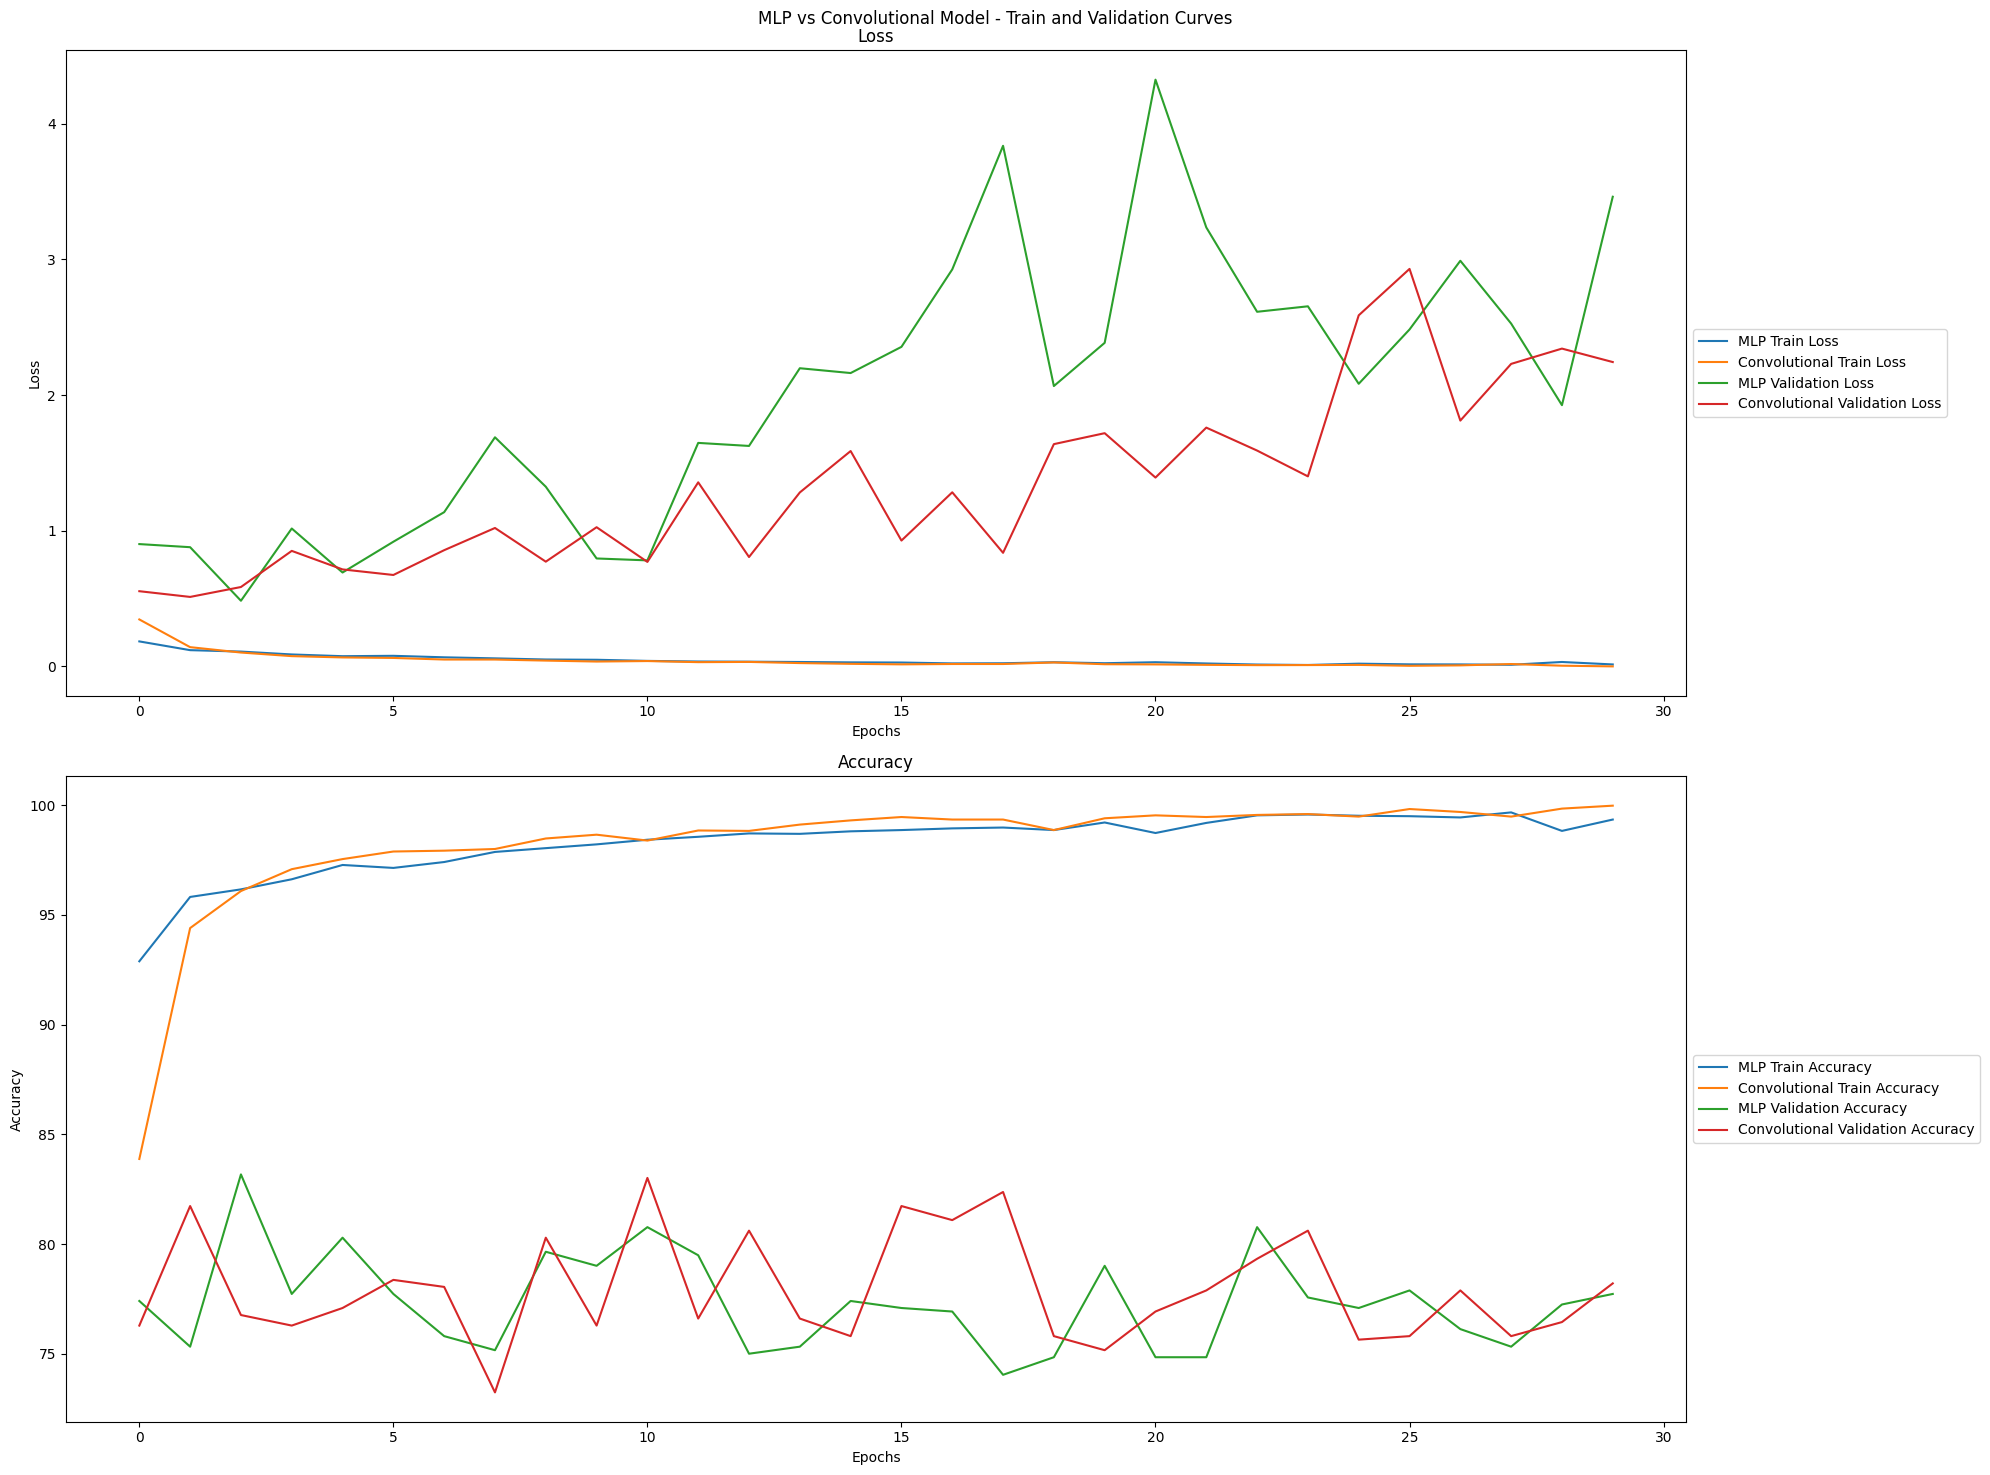

In [20]:

fig, axes = plt.subplots(2, 1, figsize=(20, 15))

axes[0].plot(mlpCurves[0], label='MLP Train Loss')
axes[0].plot(convCurves[0], label='Convolutional Train Loss')
axes[0].plot(mlpCurves[2], label='MLP Validation Loss')
axes[0].plot(convCurves[2], label='Convolutional Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_title('Loss')

axes[1].plot(mlpCurves[1], label='MLP Train Accuracy')
axes[1].plot(convCurves[1], label='Convolutional Train Accuracy')
axes[1].plot(mlpCurves[3], label='MLP Validation Accuracy')
axes[1].plot(convCurves[3], label='Convolutional Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Accuracy')

fig.suptitle('MLP vs Convolutional Model - Train and Validation Curves')

fig.set_tight_layout(True)

plt.show()

### 2. [Total 30 pts] Add Regularization to your convolutional (CNN) model

Regularization is a common technique used in deep learning to prevent overfitting in models. In this task, you should choose two popular regularization techniques.

#### [15 pts] Train a convolutional neural network with the first regularization technique you have chosen.

#### L2 Regularization

The first selected regularization technique is L2 regularization. This technique, also known as weight decay, is used to prevent overfitting in neural networks. It works by adding a penalty term to the loss function, proportional to the squared magnitude of the model weights. This penalty discourages large weight values during training, effectively penalizing models with large weights and promoting more well distributed weight values. By incorporating L2 regularization, the model learns to generalize better to unseen data, as it reduces the likelihood of overfitting caused by large weights that overemphasize the importance of specific features.

##### Training the CNN Model with L2 Regularization

To add L2 regularization in PyTorch, we can use the `weight_decay` parameter in the optimizer (Adam in this case).

In [21]:
l2Regularization = 1e-3

convModelL2 = ConvModel()
convModelL2 = convModelL2.to(device)
resetModelWeights(convModelL2)

convL2Curves = fit(trainLoader, valLoader, convModelL2, Adam(convModelL2.parameters(), lr=learningRate, weight_decay=l2Regularization), nn.CrossEntropyLoss(), nEpochs, device)

del convModelL2

Testing Epoch 1/30: 100%|██████████| 20/20 [00:00<00:00, 183.11it/s]


Epoch 1/30: trainLoss: 0.3416, trainAccuracy: 83.6273, valLoss: 0.4503, valAccuracy: 82.5321


Testing Epoch 2/30: 100%|██████████| 20/20 [00:00<00:00, 167.08it/s]


Epoch 2/30: trainLoss: 0.1425, trainAccuracy: 94.4402, valLoss: 0.5962, valAccuracy: 77.8846


Testing Epoch 3/30: 100%|██████████| 20/20 [00:00<00:00, 202.63it/s]


Epoch 3/30: trainLoss: 0.1116, trainAccuracy: 95.7630, valLoss: 0.5583, valAccuracy: 77.7244


Testing Epoch 4/30: 100%|██████████| 20/20 [00:00<00:00, 202.35it/s]


Epoch 4/30: trainLoss: 0.0791, trainAccuracy: 97.1434, valLoss: 0.9120, valAccuracy: 73.8782


Testing Epoch 5/30: 100%|██████████| 20/20 [00:00<00:00, 162.16it/s]


Epoch 5/30: trainLoss: 0.0740, trainAccuracy: 97.2009, valLoss: 0.5754, valAccuracy: 79.9679


Testing Epoch 6/30: 100%|██████████| 20/20 [00:00<00:00, 203.40it/s]


Epoch 6/30: trainLoss: 0.0703, trainAccuracy: 97.4502, valLoss: 0.4224, valAccuracy: 83.4936


Testing Epoch 7/30: 100%|██████████| 20/20 [00:00<00:00, 117.74it/s]


Epoch 7/30: trainLoss: 0.0606, trainAccuracy: 97.4502, valLoss: 0.9305, valAccuracy: 75.6410


Testing Epoch 8/30: 100%|██████████| 20/20 [00:00<00:00, 101.56it/s]


Epoch 8/30: trainLoss: 0.0615, trainAccuracy: 97.6227, valLoss: 0.6337, valAccuracy: 82.0513


Testing Epoch 9/30: 100%|██████████| 20/20 [00:00<00:00, 167.52it/s]


Epoch 9/30: trainLoss: 0.0538, trainAccuracy: 97.9294, valLoss: 0.8098, valAccuracy: 76.4423


Testing Epoch 10/30: 100%|██████████| 20/20 [00:00<00:00, 145.88it/s]


Epoch 10/30: trainLoss: 0.0572, trainAccuracy: 97.9870, valLoss: 1.1526, valAccuracy: 73.0769


Testing Epoch 11/30: 100%|██████████| 20/20 [00:00<00:00, 202.16it/s]


Epoch 11/30: trainLoss: 0.0417, trainAccuracy: 98.3129, valLoss: 0.7945, valAccuracy: 81.0897


Testing Epoch 12/30: 100%|██████████| 20/20 [00:00<00:00, 180.70it/s]


Epoch 12/30: trainLoss: 0.0479, trainAccuracy: 98.2362, valLoss: 0.6912, valAccuracy: 81.5705


Testing Epoch 13/30: 100%|██████████| 20/20 [00:00<00:00, 122.36it/s]


Epoch 13/30: trainLoss: 0.0327, trainAccuracy: 98.5813, valLoss: 0.6330, valAccuracy: 81.4103


Testing Epoch 14/30: 100%|██████████| 20/20 [00:00<00:00, 184.42it/s]


Epoch 14/30: trainLoss: 0.0344, trainAccuracy: 98.8497, valLoss: 1.4492, valAccuracy: 73.8782


Testing Epoch 15/30: 100%|██████████| 20/20 [00:00<00:00, 208.07it/s]


Epoch 15/30: trainLoss: 0.0381, trainAccuracy: 98.5238, valLoss: 0.8118, valAccuracy: 78.6859


Testing Epoch 16/30: 100%|██████████| 20/20 [00:00<00:00, 184.95it/s]


Epoch 16/30: trainLoss: 0.0319, trainAccuracy: 98.5813, valLoss: 0.9349, valAccuracy: 79.3269


Testing Epoch 17/30: 100%|██████████| 20/20 [00:00<00:00, 152.26it/s]


Epoch 17/30: trainLoss: 0.0281, trainAccuracy: 98.6580, valLoss: 0.7808, valAccuracy: 81.8910


Testing Epoch 18/30: 100%|██████████| 20/20 [00:00<00:00, 149.85it/s]


Epoch 18/30: trainLoss: 0.0306, trainAccuracy: 98.9072, valLoss: 0.6385, valAccuracy: 83.4936


Testing Epoch 19/30: 100%|██████████| 20/20 [00:00<00:00, 155.78it/s]


Epoch 19/30: trainLoss: 0.0210, trainAccuracy: 99.3290, valLoss: 1.7406, valAccuracy: 75.0000


Testing Epoch 20/30: 100%|██████████| 20/20 [00:00<00:00, 165.08it/s]


Epoch 20/30: trainLoss: 0.0249, trainAccuracy: 99.1756, valLoss: 1.0212, valAccuracy: 79.3269


Testing Epoch 21/30: 100%|██████████| 20/20 [00:00<00:00, 194.19it/s]


Epoch 21/30: trainLoss: 0.0229, trainAccuracy: 99.2331, valLoss: 1.1245, valAccuracy: 78.2051


Testing Epoch 22/30: 100%|██████████| 20/20 [00:00<00:00, 175.09it/s]


Epoch 22/30: trainLoss: 0.0186, trainAccuracy: 99.2523, valLoss: 1.7533, valAccuracy: 74.1987


Testing Epoch 23/30: 100%|██████████| 20/20 [00:00<00:00, 178.01it/s]


Epoch 23/30: trainLoss: 0.0171, trainAccuracy: 99.4440, valLoss: 1.2899, valAccuracy: 77.5641


Testing Epoch 24/30: 100%|██████████| 20/20 [00:00<00:00, 200.64it/s]


Epoch 24/30: trainLoss: 0.0145, trainAccuracy: 99.5590, valLoss: 0.9096, valAccuracy: 79.9679


Testing Epoch 25/30: 100%|██████████| 20/20 [00:00<00:00, 188.99it/s]


Epoch 25/30: trainLoss: 0.0142, trainAccuracy: 99.4248, valLoss: 1.5542, valAccuracy: 74.0385


Testing Epoch 26/30: 100%|██████████| 20/20 [00:00<00:00, 181.25it/s]


Epoch 26/30: trainLoss: 0.0116, trainAccuracy: 99.5399, valLoss: 0.8667, valAccuracy: 83.0128


Testing Epoch 27/30: 100%|██████████| 20/20 [00:00<00:00, 103.59it/s]


Epoch 27/30: trainLoss: 0.0130, trainAccuracy: 99.5399, valLoss: 1.4811, valAccuracy: 74.8397


Testing Epoch 28/30: 100%|██████████| 20/20 [00:00<00:00, 140.57it/s]


Epoch 28/30: trainLoss: 0.0265, trainAccuracy: 98.9072, valLoss: 1.3574, valAccuracy: 75.8013


Testing Epoch 29/30: 100%|██████████| 20/20 [00:00<00:00, 175.55it/s]


Epoch 29/30: trainLoss: 0.0141, trainAccuracy: 99.5207, valLoss: 0.9062, valAccuracy: 79.0064


Testing Epoch 30/30: 100%|██████████| 20/20 [00:00<00:00, 181.47it/s]

Epoch 30/30: trainLoss: 0.0085, trainAccuracy: 99.7124, valLoss: 1.3792, valAccuracy: 76.2821


#### [15 pts] Train a convolutional neural network with the second regularization technique you have chosen.

#### Dropout Regularization

The second selected regularization technique is Dropout. Dropout regularization is a technique commonly used in neural networks to prevent overfitting. During training, dropout randomly removes a fraction of neurons from the network, forcing the remaining neurons to learn more robust features independently. This process introduces noise to the network, making it less sensitive to the specific details of the training data. During inference, all neurons are used, but their outputs are scaled by the dropout probability. Dropout encourages the network to learn more generalized representations of the data, leading to better performance on unseen examples and reducing the risk of overfitting.

##### Rewriting the CNN Model with Dropout Regularization

To add Dropout regularization in PyTorch, we can use `nn.Dropout` in the model definition. Add dropout layers after the layers where you want to apply dropout.

In [22]:
class ConvModelWithDropout(nn.Module):
  
  def __init__(self):

    super(ConvModelWithDropout, self).__init__()
    
    self.conv_layers = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0), # kernel size 3x3, stride 1, 32 channels
      nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True), # kernel size 3x3, stride 2, ceil mode=True
      nn.ReLU(),
      nn.Dropout(0.35),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0), # kernel size 3x3, stride 1, 64 channels
      nn.MaxPool2d(kernel_size=3, stride=2), # kernel size 3x3, stride 2
      nn.ReLU(),
      nn.Dropout(0.35),
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0), # kernel size 3x3, stride 1, 64 channels
      nn.MaxPool2d(kernel_size=2, stride=2), # kernel size 2x2, stride 2
      nn.ReLU(),
      nn.Dropout(0.35),
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0), # kernel size 2x2, stride 1, 128 channels
      nn.ReLU(),
      nn.Dropout(0.35),
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0), # kernel size 3x3, stride 1, 256 channels
      nn.ReLU(),
      nn.Dropout(0.35),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0), # kernel size 3x3, stride 1, 256 channels
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels=2, kernel_size=1, stride=1, padding=0), # kernel size 1x1, stride 1, 2 channels
    )

  def forward(self, input):
    return self.conv_layers(input).view(input.size(0), -1) # Flatten the output

In [23]:
model = ConvModelWithDropout()

print(model)
summary(model, (3, targetSize[0], targetSize[1]))

ConvModelWithDropout(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): ReLU()
    (3): Dropout(p=0.35, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): Dropout(p=0.35, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): Dropout(p=0.35, inplace=False)
    (12): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (13): ReLU()
    (14): Dropout(p=0.35, inplace=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (16): ReLU()
    (17): Dropout(p=0.35, inplace=False)
    (18): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (19): ReLU()
    (20): Conv2d(256, 2, kernel_si

##### Training the CNN Model with Dropout Regularization

In [24]:
convModelWithDropout = ConvModelWithDropout()
convModelWithDropout = convModelWithDropout.to(device)
resetModelWeights(convModelWithDropout)

convWithDropoutCurves = fit(trainLoader, valLoader, convModelWithDropout, Adam(convModelWithDropout.parameters(), lr=learningRate), nn.CrossEntropyLoss(), nEpochs, device)

del convModelWithDropout

Testing Epoch 1/30: 100%|██████████| 20/20 [00:00<00:00, 190.74it/s]


Epoch 1/30: trainLoss: 0.4279, trainAccuracy: 79.4287, valLoss: 0.4095, valAccuracy: 83.9744


Testing Epoch 2/30: 100%|██████████| 20/20 [00:00<00:00, 201.36it/s]


Epoch 2/30: trainLoss: 0.2093, trainAccuracy: 91.6028, valLoss: 0.3448, valAccuracy: 84.7756


Testing Epoch 3/30: 100%|██████████| 20/20 [00:00<00:00, 161.26it/s]


Epoch 3/30: trainLoss: 0.1546, trainAccuracy: 93.7500, valLoss: 0.4559, valAccuracy: 79.1667


Testing Epoch 4/30: 100%|██████████| 20/20 [00:00<00:00, 202.43it/s]


Epoch 4/30: trainLoss: 0.1290, trainAccuracy: 94.7086, valLoss: 0.7236, valAccuracy: 74.1987


Testing Epoch 5/30: 100%|██████████| 20/20 [00:00<00:00, 192.68it/s]


Epoch 5/30: trainLoss: 0.1118, trainAccuracy: 95.7822, valLoss: 0.4361, valAccuracy: 83.3333


Testing Epoch 6/30: 100%|██████████| 20/20 [00:00<00:00, 191.01it/s]


Epoch 6/30: trainLoss: 0.0985, trainAccuracy: 96.2615, valLoss: 1.1054, valAccuracy: 72.2756


Testing Epoch 7/30: 100%|██████████| 20/20 [00:00<00:00, 182.36it/s]


Epoch 7/30: trainLoss: 0.1050, trainAccuracy: 96.3765, valLoss: 0.5308, valAccuracy: 79.8077


Testing Epoch 8/30: 100%|██████████| 20/20 [00:00<00:00, 189.04it/s]


Epoch 8/30: trainLoss: 0.0933, trainAccuracy: 96.6641, valLoss: 0.4912, valAccuracy: 81.2500


Testing Epoch 9/30: 100%|██████████| 20/20 [00:00<00:00, 184.09it/s]


Epoch 9/30: trainLoss: 0.0986, trainAccuracy: 96.4149, valLoss: 0.6954, valAccuracy: 79.4872


Testing Epoch 10/30: 100%|██████████| 20/20 [00:00<00:00, 190.63it/s]


Epoch 10/30: trainLoss: 0.0881, trainAccuracy: 96.7600, valLoss: 1.0219, valAccuracy: 72.1154


Testing Epoch 11/30: 100%|██████████| 20/20 [00:00<00:00, 208.23it/s]


Epoch 11/30: trainLoss: 0.0870, trainAccuracy: 96.8750, valLoss: 0.7651, valAccuracy: 79.9679


Testing Epoch 12/30: 100%|██████████| 20/20 [00:00<00:00, 223.84it/s]


Epoch 12/30: trainLoss: 0.0785, trainAccuracy: 97.2009, valLoss: 1.0543, valAccuracy: 73.7179


Testing Epoch 13/30: 100%|██████████| 20/20 [00:00<00:00, 199.89it/s]


Epoch 13/30: trainLoss: 0.0746, trainAccuracy: 97.0859, valLoss: 0.7150, valAccuracy: 76.2821


Testing Epoch 14/30: 100%|██████████| 20/20 [00:00<00:00, 208.08it/s]


Epoch 14/30: trainLoss: 0.0727, trainAccuracy: 97.2393, valLoss: 0.7511, valAccuracy: 74.1987


Testing Epoch 15/30: 100%|██████████| 20/20 [00:00<00:00, 184.57it/s]


Epoch 15/30: trainLoss: 0.0694, trainAccuracy: 97.3543, valLoss: 1.4266, valAccuracy: 75.1603


Testing Epoch 16/30: 100%|██████████| 20/20 [00:00<00:00, 161.05it/s]


Epoch 16/30: trainLoss: 0.0718, trainAccuracy: 97.1242, valLoss: 1.0944, valAccuracy: 79.0064


Testing Epoch 17/30: 100%|██████████| 20/20 [00:00<00:00, 157.24it/s]


Epoch 17/30: trainLoss: 0.0700, trainAccuracy: 97.3543, valLoss: 0.9403, valAccuracy: 76.7628


Testing Epoch 18/30: 100%|██████████| 20/20 [00:00<00:00, 187.87it/s]


Epoch 18/30: trainLoss: 0.0705, trainAccuracy: 97.1817, valLoss: 0.8651, valAccuracy: 79.3269


Testing Epoch 19/30: 100%|██████████| 20/20 [00:00<00:00, 234.44it/s]


Epoch 19/30: trainLoss: 0.0714, trainAccuracy: 97.2776, valLoss: 0.5819, valAccuracy: 84.1346


Testing Epoch 20/30: 100%|██████████| 20/20 [00:00<00:00, 202.30it/s]


Epoch 20/30: trainLoss: 0.0619, trainAccuracy: 97.7377, valLoss: 1.1993, valAccuracy: 75.8013


Testing Epoch 21/30: 100%|██████████| 20/20 [00:00<00:00, 214.00it/s]


Epoch 21/30: trainLoss: 0.0663, trainAccuracy: 97.5268, valLoss: 0.4470, valAccuracy: 84.4551


Testing Epoch 22/30: 100%|██████████| 20/20 [00:00<00:00, 188.67it/s]


Epoch 22/30: trainLoss: 0.0688, trainAccuracy: 97.2776, valLoss: 1.3908, valAccuracy: 72.4359


Testing Epoch 23/30: 100%|██████████| 20/20 [00:00<00:00, 188.70it/s]


Epoch 23/30: trainLoss: 0.0578, trainAccuracy: 97.7569, valLoss: 0.7091, valAccuracy: 80.2885


Testing Epoch 24/30: 100%|██████████| 20/20 [00:00<00:00, 177.00it/s]


Epoch 24/30: trainLoss: 0.0600, trainAccuracy: 97.6419, valLoss: 0.9008, valAccuracy: 77.5641


Testing Epoch 25/30: 100%|██████████| 20/20 [00:00<00:00, 196.54it/s]


Epoch 25/30: trainLoss: 0.0538, trainAccuracy: 97.9294, valLoss: 1.1830, valAccuracy: 78.0449


Testing Epoch 26/30: 100%|██████████| 20/20 [00:00<00:00, 185.24it/s]


Epoch 26/30: trainLoss: 0.0573, trainAccuracy: 97.7952, valLoss: 1.3660, valAccuracy: 75.1603


Testing Epoch 27/30: 100%|██████████| 20/20 [00:00<00:00, 194.83it/s]


Epoch 27/30: trainLoss: 0.0619, trainAccuracy: 97.6419, valLoss: 0.7888, valAccuracy: 83.3333


Testing Epoch 28/30: 100%|██████████| 20/20 [00:00<00:00, 201.44it/s]


Epoch 28/30: trainLoss: 0.0521, trainAccuracy: 97.8911, valLoss: 1.1598, valAccuracy: 76.6026


Testing Epoch 29/30: 100%|██████████| 20/20 [00:00<00:00, 201.35it/s]


Epoch 29/30: trainLoss: 0.0540, trainAccuracy: 97.7186, valLoss: 1.1040, valAccuracy: 77.0833


Testing Epoch 30/30: 100%|██████████| 20/20 [00:00<00:00, 220.50it/s]

Epoch 30/30: trainLoss: 0.0519, trainAccuracy: 98.0253, valLoss: 1.0994, valAccuracy: 77.8846


##### Plotting the Loss and Accuracy Curves of all Models seen so far

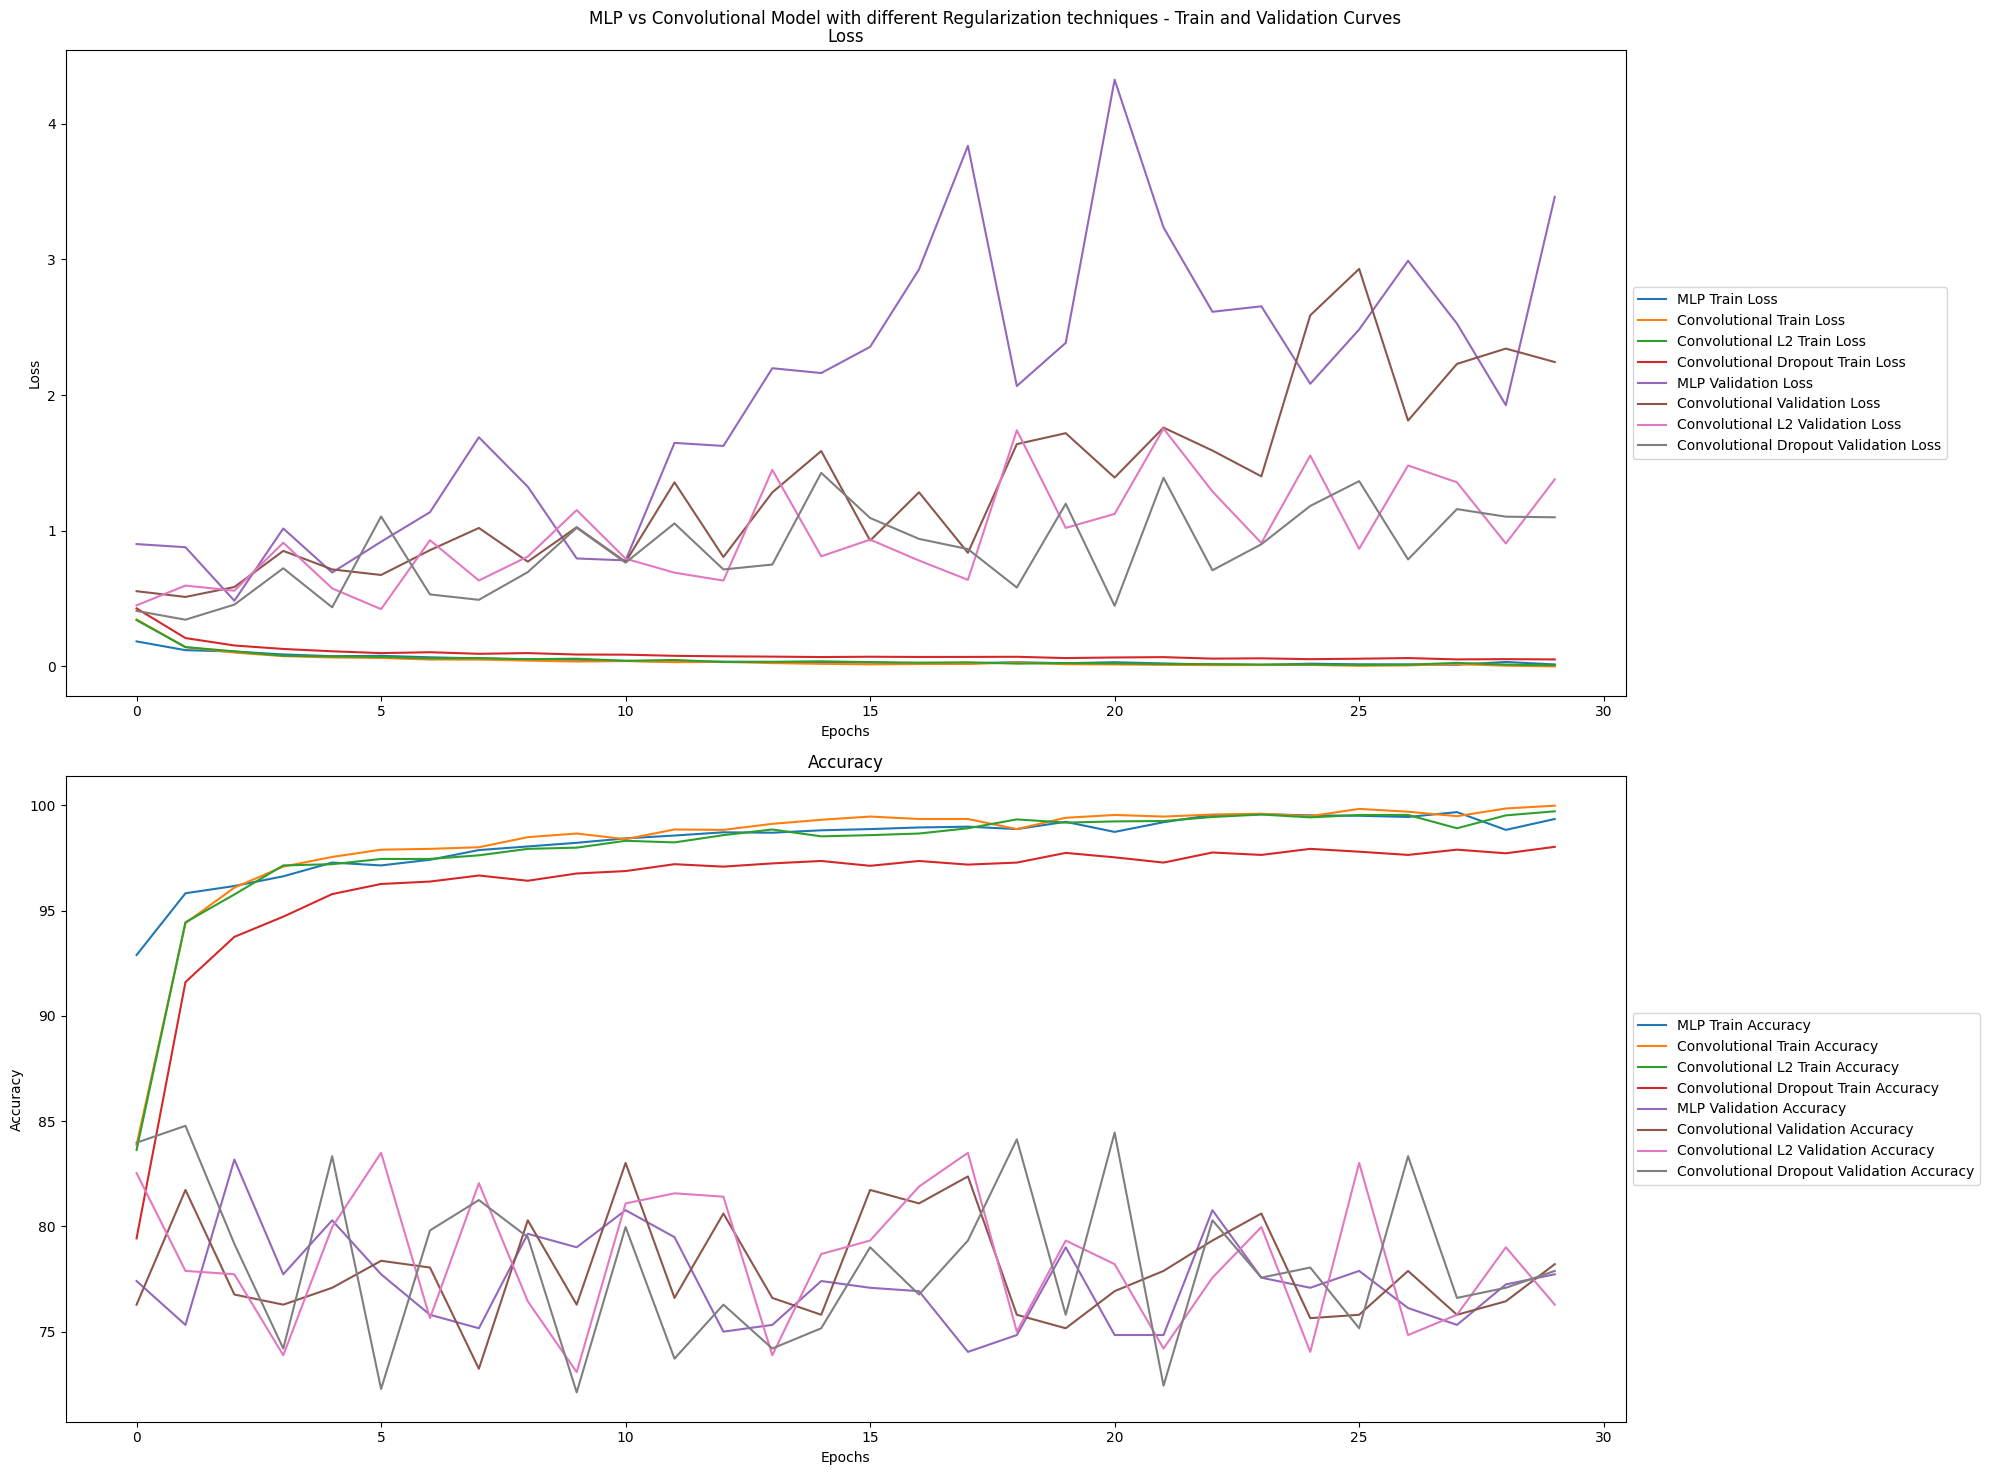

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

axes[0].plot(mlpCurves[0], label='MLP Train Loss')
axes[0].plot(convCurves[0], label='Convolutional Train Loss')
axes[0].plot(convL2Curves[0], label='Convolutional L2 Train Loss')
axes[0].plot(convWithDropoutCurves[0], label='Convolutional Dropout Train Loss')
axes[0].plot(mlpCurves[2], label='MLP Validation Loss')
axes[0].plot(convCurves[2], label='Convolutional Validation Loss')
axes[0].plot(convL2Curves[2], label='Convolutional L2 Validation Loss')
axes[0].plot(convWithDropoutCurves[2], label='Convolutional Dropout Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_title('Loss')

axes[1].plot(mlpCurves[1], label='MLP Train Accuracy')
axes[1].plot(convCurves[1], label='Convolutional Train Accuracy')
axes[1].plot(convL2Curves[1], label='Convolutional L2 Train Accuracy')
axes[1].plot(convWithDropoutCurves[1], label='Convolutional Dropout Train Accuracy')
axes[1].plot(mlpCurves[3], label='MLP Validation Accuracy')
axes[1].plot(convCurves[3], label='Convolutional Validation Accuracy')
axes[1].plot(convL2Curves[3], label='Convolutional L2 Validation Accuracy')
axes[1].plot(convWithDropoutCurves[3], label='Convolutional Dropout Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Accuracy')

fig.suptitle('MLP vs Convolutional Model with different Regularization techniques - Train and Validation Curves')

fig.set_tight_layout(True)

plt.show()

### 3. [10 pts] Comment the results.

At the conclusion (last cell) of your Jupyter notebook, please provide the final validation accuracies for the following scenarios:

- Validation accuracy for a fully connected neural network.
- Validation accuracy for a convolutional neural network.
- Validation accuracy for a convolutional neural network with the first regularization technique applied.
- Validation accuracy for a convolutional neural network with the second regularization technique applied

Additionally, comment your results. Identify which model achieved the highest score and explain the reasons behind its success. Discuss potential enhancements that could be implemented to improve accuracy. Lastly, analyze why the performance of other models may not have matched that of the best-performing one.

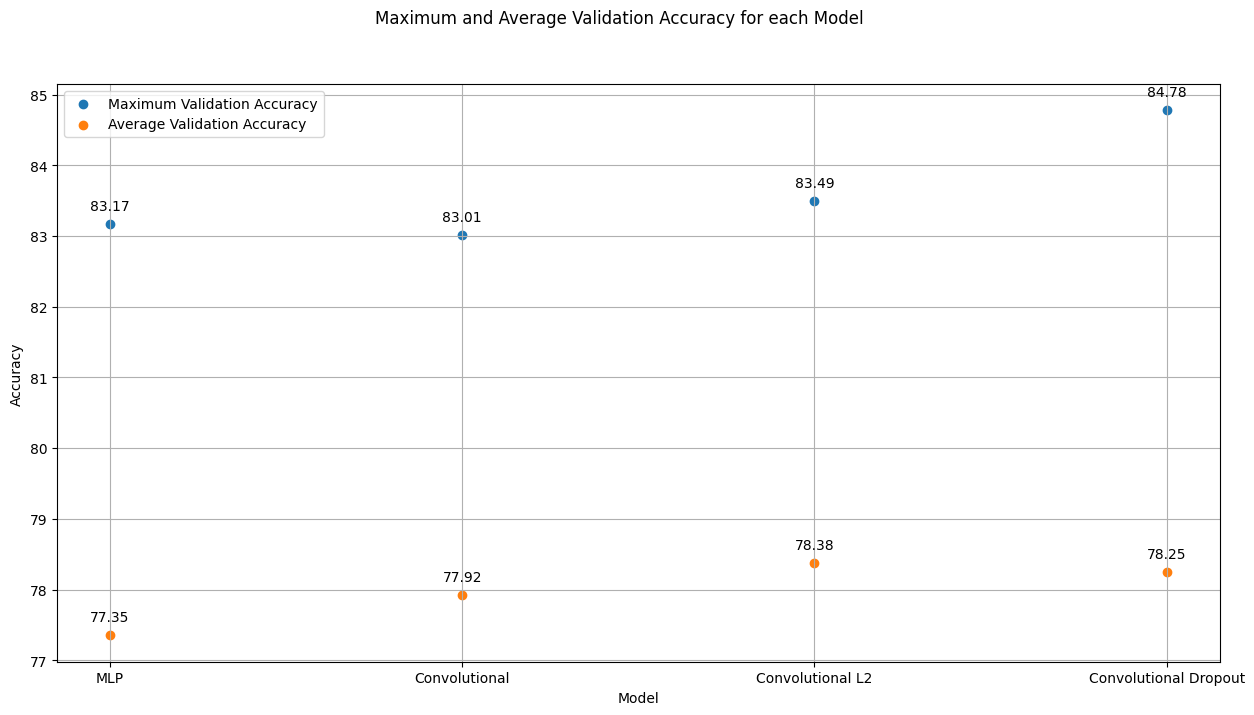

In [26]:
fig, ax = plt.subplots(figsize=(15, 7.5))

maxValAccuracies = [max(mlpCurves[3]), max(convCurves[3]), max(convL2Curves[3]), max(convWithDropoutCurves[3])]

avgValAccuracies = [np.mean(mlpCurves[3]), np.mean(convCurves[3]), np.mean(convL2Curves[3]), np.mean(convWithDropoutCurves[3])]

modelNames = ['MLP', 'Convolutional', 'Convolutional L2', 'Convolutional Dropout']

ax.scatter(modelNames, maxValAccuracies, label='Maximum Validation Accuracy')
ax.scatter(modelNames, avgValAccuracies, label='Average Validation Accuracy')

for i, txt in enumerate(maxValAccuracies):
    ax.annotate(f'{txt:.2f}', (i, maxValAccuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

for i, txt in enumerate(avgValAccuracies):
    ax.annotate(f'{txt:.2f}', (i, avgValAccuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')

ax.legend()
ax.grid(True)

fig.suptitle('Maximum and Average Validation Accuracy for each Model')

plt.show()


#### Results Analysis

Regarding the maximum validation accuracy, the model that achieved the highest score was the CNN model with Dropout Regularization followed by the CNN model with L2 Regularization, the MLP model and the CNN model. This shows that even though CNN models are more appropriate for image classification tasks, if not properly regularized, they can overfit the training data and underperform simpler models like the MLP.

The Dropout Regularization technique was the most effective in preventing overfitting and improving the generalization of the CNN model, leading to the highest validation accuracy. The L2 Regularization also helped to improve the performance of the CNN model, but not as effectively as Dropout.

The performance of the other models may not have matched that of the best-performing one due to overfitting, lack of regularization, or suboptimal model architecture. The MLP model may have underperformed the best model because of its lack of ability to learn spatial features from the images. The CNN model without regularization may have overfit the training data, leading to poor generalization. The CNN model with L2 Regularization may have been too constrained by the penalty term, preventing it from learning the necessary features. Overall, the Dropout Regularization technique was the most effective in improving the performance of the CNN model, leading to the highest validation accuracy.

Furthemore, one of the reasons the MLP model achieved a competitive validation accuracy could be due to the low necessity of learning complex features from the images, like detecting edges, shapes, textures and pixel positions that this task required. Most of the difference between the two classes can be found in the pixel intensity values (gray scale) of the images, which the MLP model can learn effectively because it independs of the spatial information of the images.

In respect to the average validation accuracy, as all models validation accuracy values ocilated a lot troughout the epochs, this metric is not very informative. However, the CNN model with L2 Regularization had the highest average validation accuracy, followed by the CNN model with Dropout Regularization, the CNN model and the MLP model. This big oscillation in the validation accuracy values also indicates that techiniques like early stopping could be used to take advantage of the best model weights and accuracy values achieved during the training process by stopping the training when the validation accuracy starts to decrease or similar metrics.

To further improve the accuracy of the models, additional techniques could be implemented, such as data augmentation, learning rate scheduling, and model architecture search. 